# What is this notebook about?

Here we learn how to calculate rate-of-TEC index (ROTI). Standard ROTI - with 30-second timestep and 5-minute window - is available from [SIMuRG](https://simurg.space) system. How ever it could be usefull for particular application to recalculate ROTI with different parameters. ROTI is usefull to establish ionospheric dynamics at short timesace. Below is example (the processing is made with [spitec tool](https://spitec.simurg.space/) that uses SIMuRG data) of the ionospheric effects of starship fligt and explosion on November 18, 2023 via ROTI.  

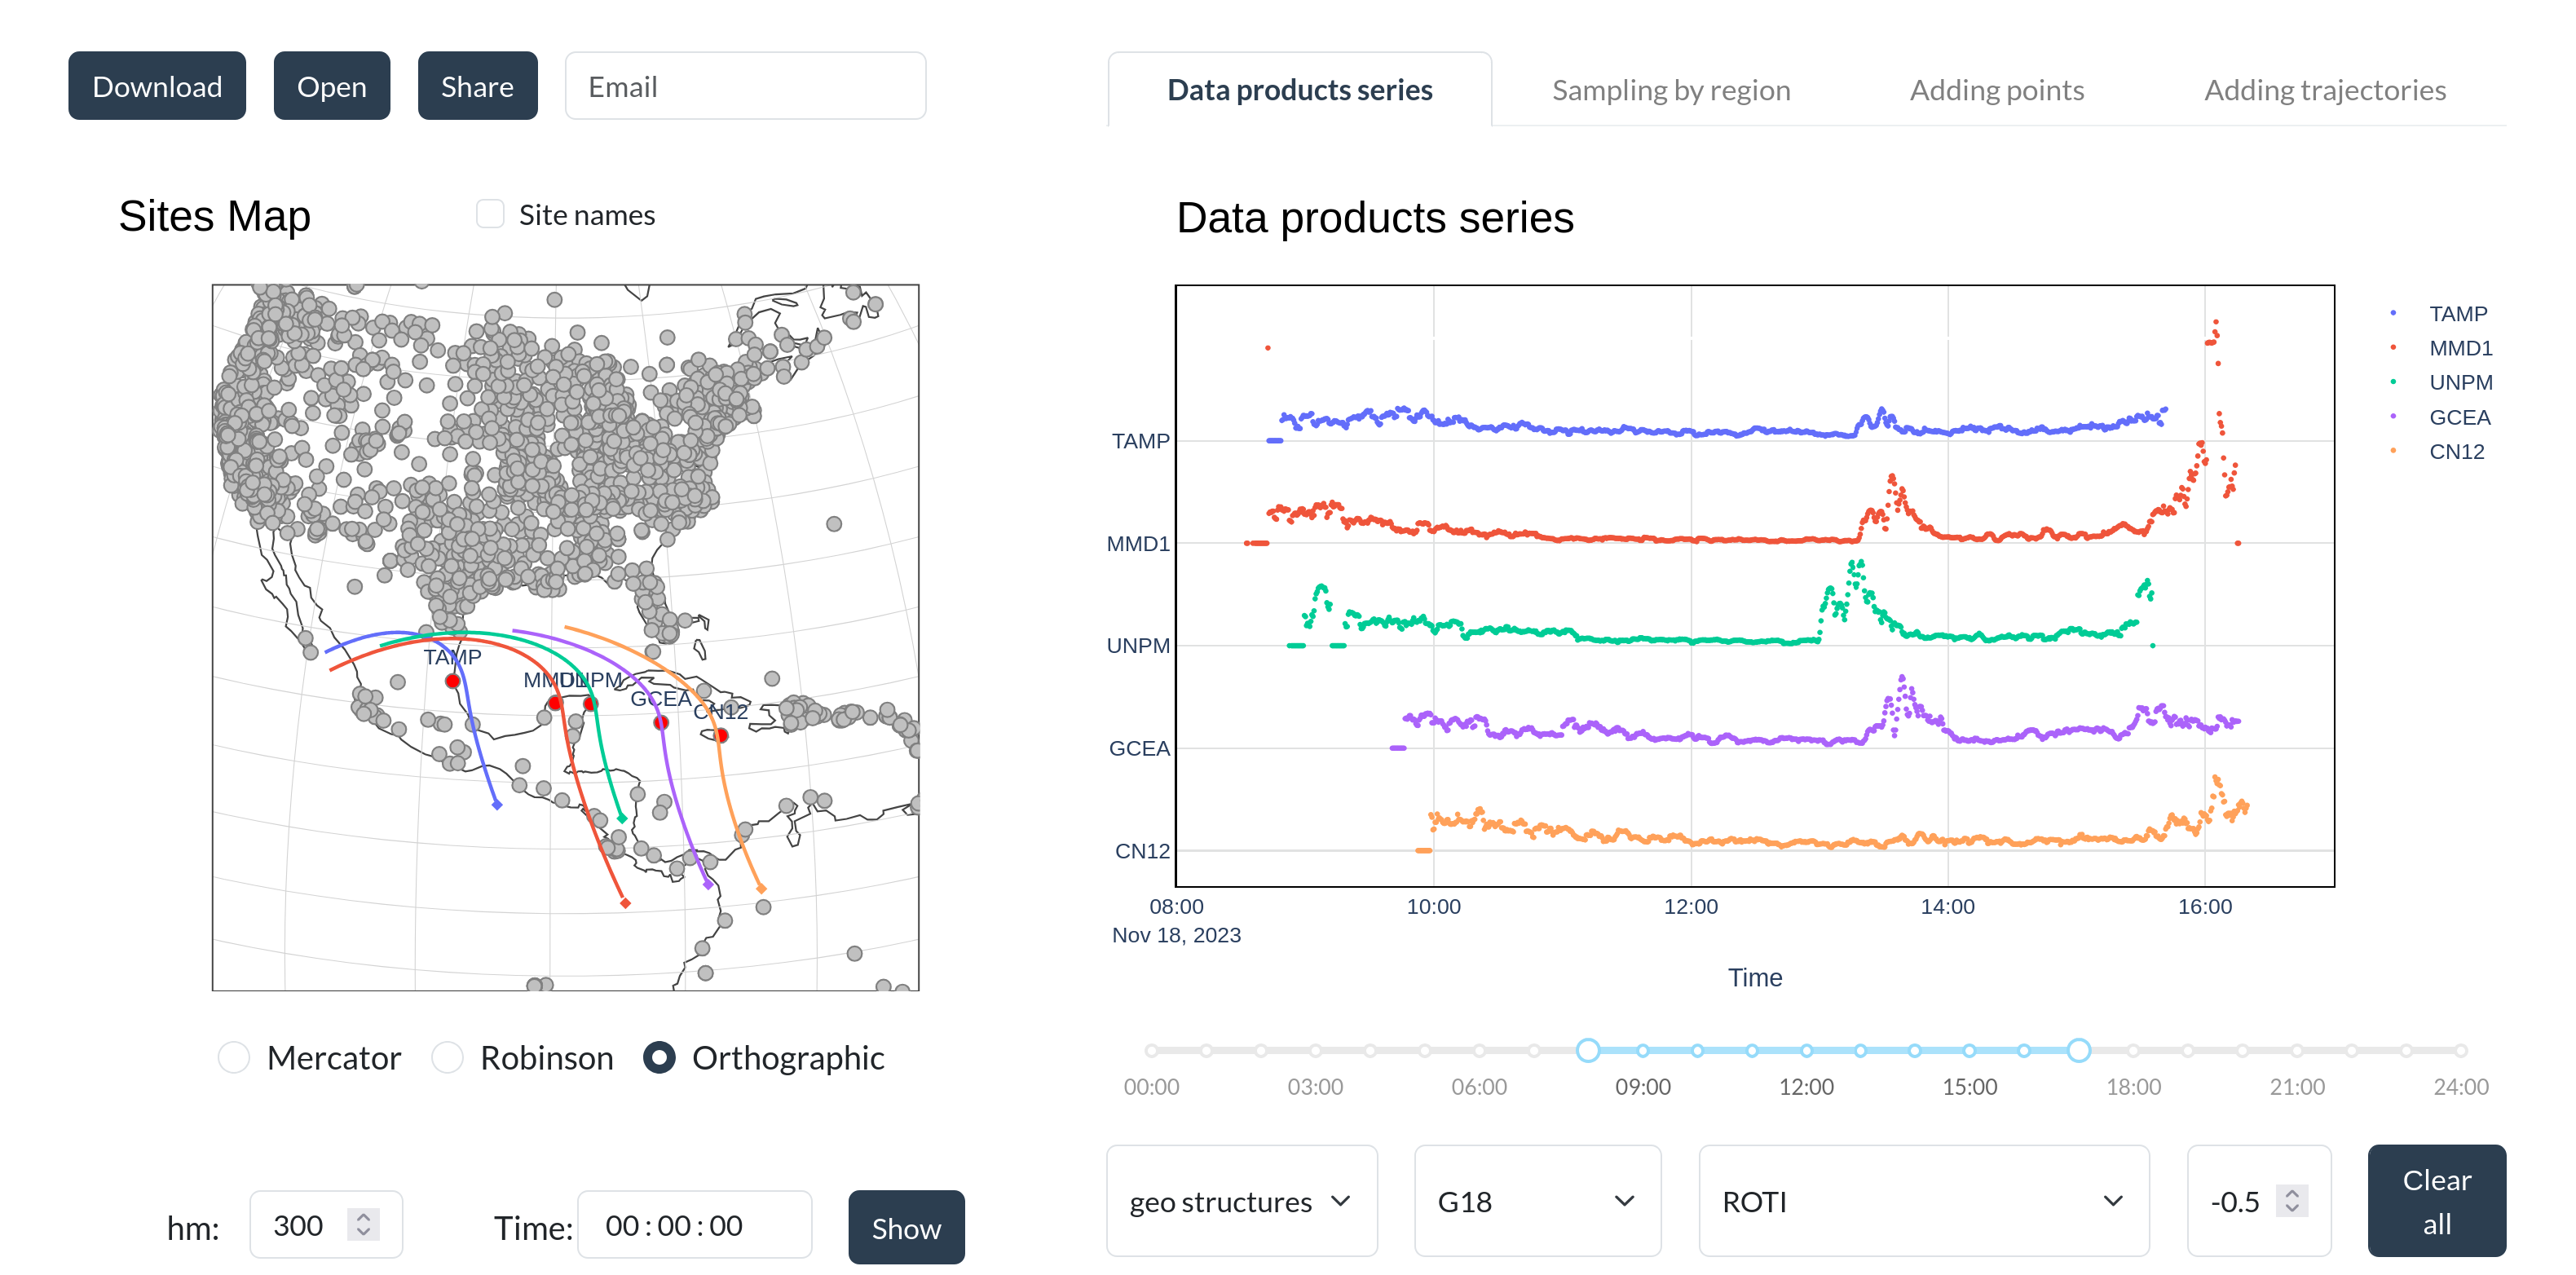

# How to start using this notebook

[Load and install](https://docs.conda.io/projects/conda/en/stable/) anaconda to make sure we on the same page. You can use **miniconda** to make download more lightweight. If link above is not working 

https://docs.conda.io/en/latest/

If you are on Windows open **Anaconda propmt**. On linux Anaconda should be available in terminal. Execute commands:

```bash
conda deactivate # to make sure we not interfere with other environments
conda create -n simurg_cases python=3.10  # create environment with proper python version
conda activate simurg_cases  # activate environment - the following commands will work in itz
conda install jupyterlab  # installing execution environment for the Notebook
conda install cartopy  # installing cartopy which recently a 
jupyter-lab  # launch execution environment for the Notebook
```

After jupyter lab is launched you will get execution enviroment for the notebook. Just click the 

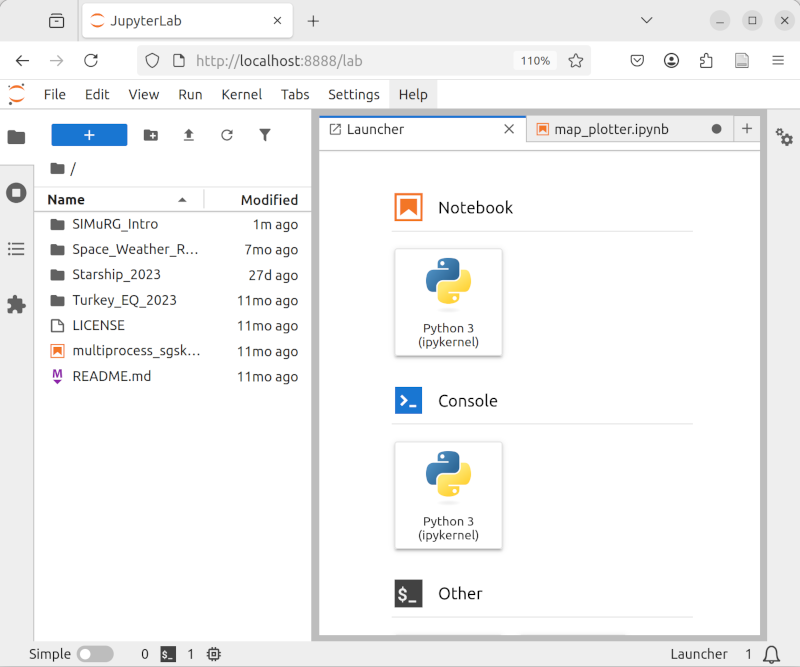

You can download this notebook and place it in the folder (or subfolder) from which you have launched `jupyter-lab`

(Optionally) To obtain all notebooks use git.

```bash
git clone https://github.com/gnss-lab/studies.git
# git checkout branch-name 
cd ./studies
```

Or download them manually from `https://github.com/gnss-lab/studies`


# Data retrieval

For illustration we will used data retrieved from SIMuRG in HDF5 format. However you can use any data format.

## Load data from simurg 

> **NOTE: SIMuRG is query based. If you need particular data go to `https://simurg.space/create_map` and select proper region and time range. Other parameters could be remains by default. After query is done you can proceed to futher processing**

Data that contain all series could be access via links like `https://simurg.space/gen_file?data=obs&date=2025-01-01`. However you can make query for single station data [here](https://simurg.space/create_series). When query is done the data are available via link like `https://simurg.space/ufiles/artemvesnin@gmail.com/dtec_2_10_2021_046_718d.h5`: exact link is in query details that could be accessed from [list of queries](https://simurg.space/queries). 

> **Note: You can check link is correct in advance by opening it in browser**

## Function for data download 

Futher we develop function for data download: function just work with url and it doesn't matter which data you use (single station or all stations). Variable `override` defines whther data should be downloaded in anyway or only when they not available locally. Function introduces progress bar via `response.iter_content()` and `sys.stdout.write()`, `sys.stdout.flush()`. The progress bar looks like:

```bash
Downloading 2025-01-05.h5 from https://simurg.space/gen_file?data=obs&date=2025-01-05
[===========================                        ]
```

In [70]:
import requests
import os
import sys
from pathlib import Path
import logging

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

def load_data(
    url: str, 
    local_file: Path,
    override: bool = False
) -> None:
    if local_file.exists() and not override:
        print(f"File {local_file} exists. Use override=True to download it again.")
        return 
        
    with open(local_file, "wb") as f:
        print(f"Downloading {local_file} from {url}")
        response = requests.get(url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None: 
            f.write(response.content)
        else:
            dl = 0
            previous = 0
            total_length = int(total_length)
            for chunk in response.iter_content(chunk_size=4096):
                dl += len(chunk)
                f.write(chunk)
                done = int(50 * dl / total_length)
                if done > previous: # to prevent warnings from notebook
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                    sys.stdout.flush()
                previous = done
            sys.stdout.write("\n")

### Data download

Now we are ready to call `load_data()`.

> **To work with your data change link `simurg.space/gen_file?data=obs&date=2025-01-05.h5` to proper one.**

> Make sure you have `override=True` or different `Path("roti.h5")` if change url.

In [71]:
from datetime import datetime
from dateutil import tz
from dataclasses import dataclass
from enum import Enum
from pathlib import Path


@dataclass
class SimurgDataFile():
    url: str
    local_path: Path


_UTC = tz.gettz('UTC')
filename = "station_data.h5"

station_files = {
    "eliv": SimurgDataFile(
        f"https://simurg.space/ufiles/artemvesnin@gmail.com/dtec_2_10_2021_046_718d.h5", 
        Path(filename),
    ),
}
for date, data_file in series_files.items():
    load_data(data_file.url, data_file.local_path, override=True)

[==================================================]


## Data structure

Now lets look at file and see how to select ROTI:

```
HDF_FILE
    -> site1 (attributes: lat, lon)
        -> sat1
            -> timestamp
            -> azimuth 
            -> dtec_10_20
            -> dtec_20_60
            -> dtec_2_10
            -> elevation
            -> roti
            -> tec
            -> tec_adjusted
        -> sat2
            -> data
        ...
    ...
    -> siteN (attributes: lat, lon)
```

We see how data are grouped. **Site** group goes first, **satellite** groups are the next level, and finally we go to the **data products**. Site group also has **attributes** that store information relevant to Site - for example coordinates.

Lets define several structures to keep data in groups. We call separate kind of data as **data product**. So ROTI and TEC are different dataproducts. To deal with different data products you can extend members of `DataProducts` with that products. 

### Check data exist in file

In [72]:
import h5py

f = h5py.File(filename)
site_names = list(f.keys())
# code below assumes file contains at least 1 station and 1 GNSS system
if site_names:
    site = site_names[0]
    sat_names = list(f[site].keys())
    if sat_names:
        sat = sat_names[10]
        print(f"For station {site} and satellite {sat} data in file are: {list(f[site][sat].keys())}")
    else:
        raise ValueError(f"There is no satellites for {site}")
else:
    raise ValueError(f"There is no data in file {filename}")

For station eiiv and satellite G12 data in file are: ['azimuth', 'dtec_10_20', 'dtec_20_60', 'dtec_2_10', 'elevation', 'roti', 'sip_larc', 'sip_lat', 'sip_lon', 'tec', 'tec_adjusted', 'timestamp']


In [105]:
from dataclasses import dataclass
from enum import Enum
from pathlib import Path

@dataclass(frozen=True)
class DataLimits():
    min: float
    max: float
    units: str

@dataclass(frozen=True)
class DataProduct(): 
    long_name: str
    hdf_name: str
    color_limits: DataLimits

class DataProducts(Enum):
    roti = DataProduct("ROTI", "roti", DataLimits(-0, 0.5, 'TECU/min'))
    dtec_2_10 = DataProduct("2-10 minute TEC variations", "dtec_2_10", DataLimits(-0.4, 0.4, 'TECU'))
    dtec_10_20 = DataProduct("10-20 minute TEC variations", "dtec_10_20", DataLimits(-0.6, 0.6, 'TECU'))
    dtec_20_60 = DataProduct("20-60 minute TEC variations", "dtec_20_60", DataLimits(-0.8, 0.8, 'TECU'))
    atec = DataProduct("Vertical TEC adjusted using GIM", "tec_adjusted", DataLimits(0, 50, 'TECU'))
    tec = DataProduct("Slant TEC", "tec", DataLimits(0, 50, 'TECU'))
    elevation = DataProduct("Elevation angle", "elevation", DataLimits(0, 90, 'Degrees'))
    azimuth = DataProduct("Azimuth angle", "azimuth", DataLimits(0, 360, 'Degrees'))
    timestamp = DataProduct("Timestamp", "timestamp", None)
    time = DataProduct("Time", None, None)

In [106]:
DataProducts.roti.value

DataProduct(long_name='ROTI', hdf_name='roti', color_limits=DataLimits(min=0, max=0.5, units='TECU/min'))

# Function for data retrieval

We keep data as nested structure that repeats HDF file structure. Instead of HDF `groups` and `datasets` we use `dict` and `numpy.array` correspondingly: `dict[GnssSite, dict[GnssSat, dict[DataProduct, NDArray]]]`. Lets first define helper classes `GnssSite` and `GnssSat`. Finally we define `retrieve_data_hdf` that retrieves and returns data from HDF.

In [107]:
import h5py 
import numpy as np
from dataclasses import dataclass
from numpy.typing import NDArray

@dataclass(frozen=True)
class GnssSite:
    name: str
    lat: float
    lon: float

    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        if not isinstance(other, GnssSat):
            return NotImplemented
        return self.name == other.name

@dataclass
class GnssSat:
    name: str
    system: str
    
    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        if not isinstance(other, GnssSat):
            return NotImplemented
        return self.name == other.name

def get_sites(
    local_file: str | Path,
    min_lat: float = -90, 
    max_lat: float = 90,
    min_lon: float = -180, 
    max_lon: float = 180
) -> list[GnssSite]:    
    """Reads hdf file for site information.
    
    Coordinates are stored in site group attributes: f["SITE"].attrs.
    Coordinates are given in radians and should be converted to degree if 
    needed. Output will contain only site in region defined by min_lat, 
    max_lat, min_lon, max_lon. 
    """
    f = h5py.File(local_file)
    sites_names = list(f.keys())
    sites = list()
    for site_name in sites_names:
        site_info = f[site_name].attrs
        site_lat = np.degrees(site_info['lat'])
        site_lon = np.degrees(site_info['lon'])
        if min_lat < site_lat < max_lat and min_lon < site_lon < max_lon:
            sites.append(GnssSite(site_name, site_lat, site_lon))
    f.close()
    return sites

def retrieve_data_hdf(
    local_file: str | Path,
    sites: list[GnssSite],
) -> dict[GnssSite, dict[GnssSat, dict[DataProduct, NDArray]]]:
    """Retrieves data for given sites.
    
    Return dict with numpy arrays that contain data for given satellite.
    We addres data related to particular site and satellite as 
    result[SITE][SAT]. For example ROTI data for IRKJ site and G21 satellites
    will be retrieved from result as result["irkj"]["G21"]["roti"]
    """
    f = h5py.File(local_file)
    data = dict()
    for site in sites:
        if not site.name in f: 
            continue
        data[site] = dict()
        sats = f[site.name].keys()
        for sat_name in sats:
            sat = GnssSat(sat_name, sat_name[0])
            timestamps = f[site.name][sat.name][DataProducts.timestamp.value.hdf_name][:]
            times = [datetime.fromtimestamp(t, tz = _UTC) for t in timestamps]
            # time is not in HDF so we add it separate from loop over other data products    
            data[site][sat] = {DataProducts.time.value: np.array(times)}
            for data_product in DataProducts:
                if data_product.value.hdf_name is None:
                    continue
                data[site][sat][data_product] = f[site.name][sat.name][data_product.value.hdf_name][:]
    f.close()
    return data

## Lets examine the functions and see wether we could retrieve ROTI

In [108]:
sites = get_sites(filename)
site = sites[0]
sat = GnssSat("G10", "G")
print(f"File contains data for sites: {sites}" )
data = retrieve_data_hdf(filename, sites)
print(f"First 10 satellites for {site.name.upper()} with data are: ", list(data[site].keys())[:10])
roti_g10 = data[site][sat][DataProducts.roti]
print(f"ROTI data for {site.name.upper()} and {sat.name} are:", roti_g10[12:]) # due to 5-minute window first 11 points are zeros

File contains data for sites: [GnssSite(name='eiiv', lat=37.699629737303816, lon=15.082082039209364)]
First 10 satellites for EIIV with data are:  [GnssSat(name='G01', system='G'), GnssSat(name='G02', system='G'), GnssSat(name='G03', system='G'), GnssSat(name='G04', system='G'), GnssSat(name='G05', system='G'), GnssSat(name='G06', system='G'), GnssSat(name='G07', system='G'), GnssSat(name='G08', system='G'), GnssSat(name='G09', system='G'), GnssSat(name='G10', system='G')]
ROTI data for EIIV and G10 are: [0.01639804 0.01664601 0.01617269 ... 0.02466132 0.02366226 0.02218262]


# Calculate ROTI from scratch

We finally is about to calculate ROTI by ourselves. The values previously found in file will be great help for us since we know correct answer and can make comparison. Before we procees futher there is couple thing we need to do for the calucalation works correctly. 

### Continuous arcs

The first is to split series in continous arc i.e. time ranges when satellite visible. We apply strict criterion and make single gaps in data reason to introduce new arc.

The function processes a sequence of timestamps to identify gaps that exceed the expected `timestep`. It first computes the differences between consecutive timestamps (`np.diff`) to detect discontinuities. These discontinuities are then used to determine the boundaries between continuous observation arcs.

By identifying the indices where the gaps occur, the function constructs a list of interval bounds, which are used to slice the original timestamps into continuous segments. Finally, it pairs these bounds into tuples representing the start and end indices of each arc and returns them as a tuple of index ranges.



In [229]:
def find_continuos_arcs(timestamps: NDArray, timestep: int = 30) -> tuple[tuple[int, int]]:
    """Defines timespans of the continuous satellite observations a.k.a. arcs
    
    :param timestamps:  numpy.array 
        Timesamps of observations

    :param timestep:  int
        Exapected timestep of observations
        
    Returns: tuple[tuple[int, int]]
    A tuple of index pairs, each representing the start and end indices (
    non-inclusive of the end) of continuous arcs in the timestamps array.
    """
    deltas = np.diff(timestamps)
    gaps = list(np.where(deltas > timestep)[0] + 1)
    interval_bounds = [0] + list(gaps) + [len(timestamps)]
    arcs_indices = []
    for i in range(len(interval_bounds) - 1):
        arcs_indices.append((interval_bounds[i], interval_bounds[i + 1]))
    return tuple(arcs_indices)

### Jumps fix

TEC series often have jumps related to instrumental issues. So they need to be fixed before TEC processing since they make unphysical artifacts in data.


#### ⚙️ How It Works

1. **Jump Detection**:

   * Computes the difference using `np.diff(series)`.
   * Finds where the absolute difference exceeds `max_change`.
```python
jump_indices = np.where(np.abs(np.diff(series)) >= calculate_jump_correction)[0] + 1  
```

3. **Segmentation**:

   * Splits the series into segments at jump points.
   * The first segment is left unchanged.

4. **Correction of Subsequent Segments**:

   * For each segment after the first:

     * Computes a **linear extrapolation** from the last two points of the previous segment.
     * Computes the difference (`shift`) between the expected and actual first point of the current segment.
     * Applies a **cumulative shift** to the current segment.

5. **Result**:

   * The entire series is adjusted so that step-like jumps are smoothed out while preserving linear trends.

---

#### 🧪 Helper Function: `calculate_jump_correction`

```python
def calculate_jump_correction(series: NDArray, before_jump: int) -> float:
```

* Computes the line `y = ax + b` from the two points before the jump.
* Calculates the expected value at the first point after the jump.
* Returns the difference between expected and actual value as the correction factor.

---

#### 📌 Key Assumptions

* ⏱️ The series is sampled at **uniform time intervals**.
* 📉 The underlying signal is **locally linear** between jumps.
* 🧩 Jumps are **instantaneous**, not gradual.
* ➕ There are at least **two points** before each jump to fit a line.

---

#### ⚠️ Limitations

* ❌ Does not distinguish between **true physical jumps** and **artificial artifacts**. If series exhibit strong changes (`> max_change`) it will be interpreted as jump. **`#TODO` make jump detection adaptive**
* 🎢 Inaccurate when the true signal is **nonlinear** near jumps.
* 🔊 May incorrectly detect jumps in **noisy data**.
* 📉 Only the last two points before a jump are used; no post-jump information is considered.

In [287]:
import numpy as np

def calculate_jump_correction(
    series: NDArray,
    before_jump: int, 
):
    """ Caluclates constant to fix step-like change in series
    
    Last two points of previous segment needed to fit linear function: y = a * x + b    
    #TODO use two first points of current segment
    #TODO check linear trend is enough
    """
    x1, x2 = before_jump - 2, before_jump - 1
    y1, y2 = series[x1], series[x2]
    a = (y2 - y1) / (x2 - x1)
    b = y2 - a * x2

    # Expected value at start_cur based on previous trend
    expected = a * (before_jump + 1) + b
    actual = series[before_jump+1]
    shift = expected - actual
    return shift

def remove_tec_jumps(series, max_change=2.):
    """Removes steps from series.

    Assumes that series is on uniform timegrid
    """
    # shift by 1 to point to jump location
    jump_indices = np.where(np.abs(np.diff(series)) >= max_change)[0] + 1  

    if len(jump_indices) == 0:
        return series, jump_indices  # no jumps, nothing to do

    segment_starts = np.concatenate(([0], jump_indices))
    segment_ends = np.concatenate((jump_indices, [len(series)]))
    corrected = series.copy()
    total_shift = 0
    for k in range(1, len(segment_starts)):
        start_cur = segment_starts[k]
        end_cur = segment_ends[k]
        end_prev = segment_ends[k-1]
        shift = calculate_jump_correction(series, end_prev)
        total_shift += shift
        # Apply correction to current segment
        corrected[start_cur:end_cur] += total_shift

    return corrected, jump_indices

### Make sure that correction works

-7.0
-14.0
-16.0
-14.0
-7.0
0.0


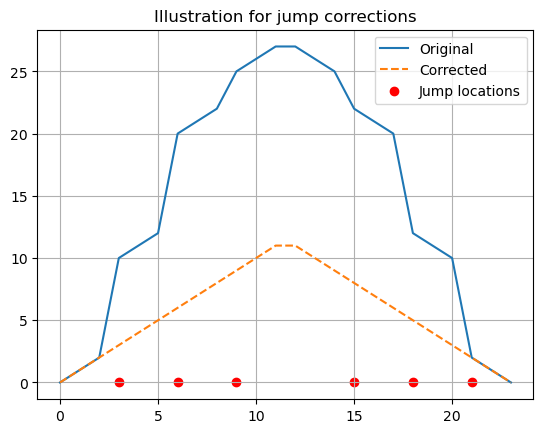

In [293]:
import matplotlib.pyplot as plt

vals = [0, 1, 2, 10, 11, 12, 20, 21, 22, 25,26,27] 
vals = vals + vals[::-1]
original = np.array(vals, dtype=float)
corrected, jump_indices = remove_phase_disruption_numpy(original, min_step=2)

plt.plot(original, label="Original")
plt.plot(corrected, label="Corrected", linestyle='--')
plt.scatter(jump_indices, np.zeros_like(np.array(jump_indices)), c="red", label="Jump locations")
plt.title("Illustration for jump corrections")
plt.legend();plt.grid();plt.show()

In [330]:
import numpy as np
from numpy.typing import NDArray

ROTI_CHOICE = {
    'simple': 'Standard', 
    'pierce_distance_normed': 'IPP distance normed', 
    'mapping_function': 'AATR'
}

def calculate_roti(
    tec: NDArray, 
    timestamps: NDArray,
    elevation: NDArray = None,
    timestep: int = 30, 
    window: int = 300, 
    choice: str='simple'
):
    """
    Calculate ROTI and ROT for given elevation and altitude.
    IMPORTANT: tec in dataset must be clerified i.e. gaps and slips are 
    handeled
    
    :param tec: NDArray
    :param timestamps: NDArray
    :param timestep: int
    :param window: int, seconds
        Window in which ROTI is calculated
    :return:    float 
	roti, rot
    """
    if not (choice == "simple" or choice == "mapping_function"):
        raise ValueError("Only simple and mapping_function ROTI is implemented yet")
    
    amount = int(window / timestep + 1)
    samples_minute = timestep / 60
    roti = np.zeros_like(tec)
    corrected_tec = np.zeros_like(tec)
    rot = (tec - np.roll(tec, 1)) / samples_minute
    for i in range(amount + 1, len(tec)): # +1 since np.roll() 
        rot_window = rot[i - amount: i]
        if choice == "simple":
            roti[i] = calculate_roti_simple(rot_window)
        elif choice == "mapping_function":
            roti[i] = calculate_roti_mapping_function(rot_window, elevation[i])
    return roti, rot


def calculate_roti_simple(rot):
    return np.std(rot)

RE_km = 6371
Hm_km_MSLM = 506.7
alpha_MSLM = 0.9782

def calculcate_MSLM_coef(elevation, h_max=Hm_km_MSLM, R=RE_km): 
    mslm_sin = np.sin(alpha_MSLM * (np.pi/2 - elevation))
    ratio = R / (R + h_max) * mslm_sin
    return np.cos(np.arcsin(ratio))

def calculate_roti_mapping_function(rot, elevation):
    mapping_coeff = calculcate_MSLM_coef(elevation)
    return np.std(rot) * mapping_coeff**2


### Extract sites from file and take the first one (it is optional, to work with different station change `sites[0]` to proper one) for futher processing

In [331]:
sites = get_sites(filename)
try:
    site = sites[0]
    print(f"Using site: {site.name.upper()}")
except:
    print(f"ERROR: Check data - no sites in file {filename}")

Using site: EIIV


### Extract data from a file

In [332]:
sat = GnssSat("G10", "G")
data = retrieve_data_hdf(filename, sites)
try: 
    sat_site_data = data[site][sat]
    print(f"Using sat: {sat.name.upper()}")
except:
    print(f"ERROR: Check data - no satellite {sat.name.upper()} in file {filename} fot site {site.name.upper()}")

Using sat: G10


In [333]:
sat_site_tec = sat_site_data[DataProducts.tec]
sat_site_roti = sat_site_data[DataProducts.roti]
sat_site_timestamps = sat_site_data[DataProducts.timestamp]
sat_site_times = sat_site_data[DataProducts.time.value]
sat_site_elevations = sat_site_data[DataProducts.elevation]

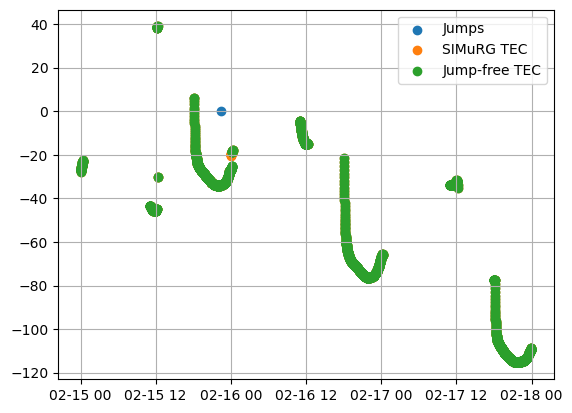

In [339]:
solids = find_continuos_arcs(sat_site_timestamps)
corrected_tec = np.zeros_like(sat_site_tec)
iarc = 0
for solid in solids:    
    arc_tec = sat_site_tec[solid[0]: solid[1]]
    corrected_arc, jumps = remove_tec_jumps(arc_tec, max_change=2)
    corrected_tec[solid[0]: solid[1]] = corrected_arc[:]
    if jumps.size > 0:
        plt.scatter(sat_site_times[jumps], np.zeros_like(jumps), label="Jumps")
    iarc = iarc + 1
plt.scatter(sat_site_times, sat_site_tec, label="SIMuRG TEC")
plt.scatter(sat_site_times, corrected_tec, label="Jump-free TEC")
plt.grid()
plt.legend()

In [350]:
calculated_roti_simple = np.zeros_like(sat_site_tec)
calculated_roti_aatr = np.zeros_like(sat_site_tec)
for solid in solids:    
    arc_roti, rot = calculate_roti(
        corrected_tec[solid[0]: solid[1]], 
        sat_site_timestamps[solid[0]: solid[1]],
        timestep = 30, 
        window = 300, 
        choice = 'simple'
    )
    calculated_roti_simple[solid[0]: solid[1]] = arc_roti[:]
    arc_roti_aatr, rot = calculate_roti(
        corrected_tec[solid[0]: solid[1]], 
        sat_site_timestamps[solid[0]: solid[1]],
        elevation = sat_site_elevations[solid[0]: solid[1]],
        timestep = 30, 
        window = 300, 
        choice = 'mapping_function'
    )
    calculated_roti_aatr[solid[0]: solid[1]] = arc_roti_aatr[:]


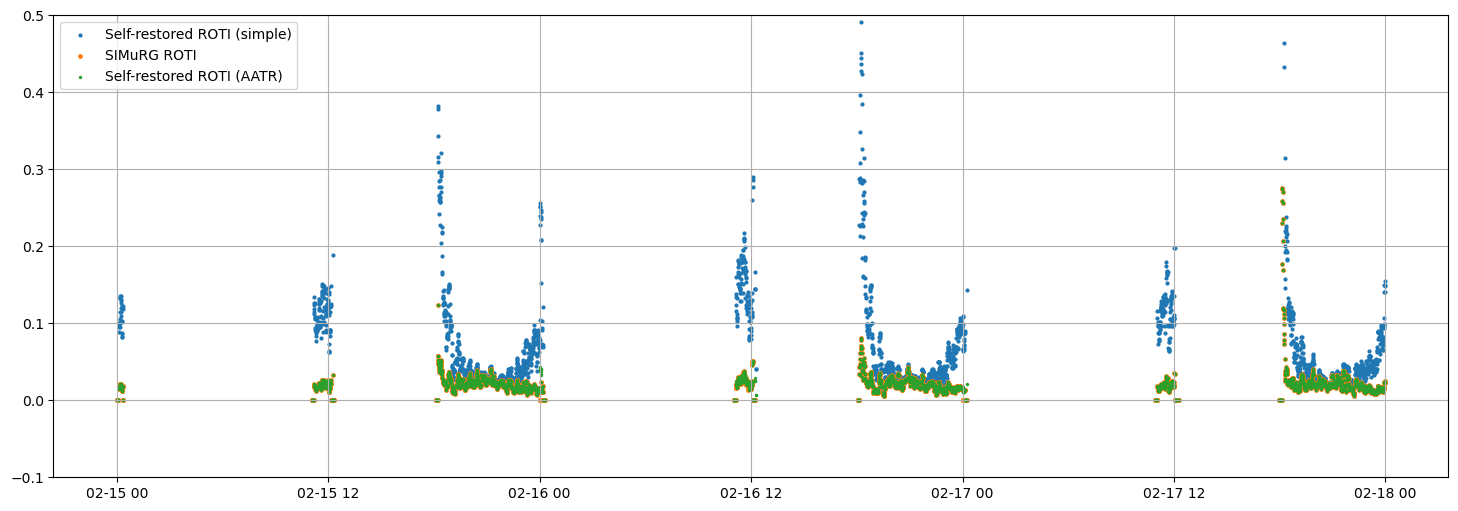

In [361]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.scatter(sat_site_times, calculated_roti, s=4, label="Self-restored ROTI (simple)")
plt.scatter(sat_site_times, sat_site_roti, s=6,  label="SIMuRG ROTI")
plt.scatter(sat_site_times, calculated_roti_aatr, s=2, label="Self-restored ROTI (AATR)")
#plt.scatter(sat_site_times, sat_site_tec, label="SIMuRG TEC")
plt.ylim(-0.1, 0.5)
plt.grid()
plt.legend()